In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'specificity_PLA' / 'metadata' / 'imgs.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs

,Condition,FOV,Path
0,Control,Control,y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
1,KO,KO,y:\coskun-lab\Thomas\23_PLA_revision\data\spec...


# PLA quantification

In [26]:
import PLA

PPI_save_path =  data_dir /   'specificity_PLA'   / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [27]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        # imgs = f['cycle1'][:]
        markers = f['cycle1'].attrs['Markers']
    print(markers)
    break

['DNA' 'Sox2/Oct4' 'Bim/Tom20']


In [ ]:
RNAs = ['Sox2/Oct4', 'Bim/Tom20']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='cycle1', m='Markers')
    
    with h5py.File(path, 'r') as f:
        markers = f['cycle1'].attrs['Markers']
        
    imgs_spots = []
    imgs_wths = []
    for RNA in RNAs: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.04, min_radius=2.5)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
        
    # Save PPI dict
    name = row[1] +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)


In [ ]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(img))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

<Image layer 'Image [2]' at 0x20645411690>

# QC segmentation

In [25]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    # mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [26]:
# Read masks paths 
mask_dir = data_dir /  'specificity_PLA'  / 'imgs' / 'masks'
mask_filt_dir = data_dir /  'specificity_PLA'  / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [27]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = row.Condition
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    mask_nuclei = mask_nuclei[:mask_cyto.shape[0], :mask_cyto.shape[1]]
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

# Extract per cell PPI count

In [6]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import scipy 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

# def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
#     if cyto:
#         columns_name = ['Cyto', 'x', 'y']
#     else:
#         columns_name = ['Nuclei', 'x', 'y']
#     df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
#                       columns=columns_name)
#     df['PPI'] = name
#     return df

def create_PPI_df(df_loc_filtered, mask_cyto, mask_nuclei, name):
    y_max, x_max = mask_cyto.shape
    y, x = df_loc_filtered['y'].to_numpy(), df_loc_filtered['x'].to_numpy()
    y = np.clip(y, a_min=0, a_max=y_max-1)
    x = np.clip(x, a_min=0, a_max=x_max-1)

    labels = mask_cyto[y, x]
    labels_nuclei = mask_nuclei[y, x]
    
    df_per_cell = pd.DataFrame({'Cyto': labels, 'Nuclei': labels_nuclei, 'y':y, 'x':x})
    df_per_cell['PPI'] = name
    return df_per_cell

def get_NN_radius(data, r):
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=True, sort_results=True)

    # Put in dataframe format
    neighbours = pd.DataFrame(m[1].tolist(), index = data.index)
    
    A = fit.radius_neighbors_graph(data)
    return neighbours, A

In [74]:
mask_filt_dir = data_dir /  'specificity_PLA'   / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir /  'specificity_PLA'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [91]:
for row in df_imgs.itertuples():
    name = row.Condition
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    df_PPIs = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Get PPI loc in panda dataframe format
        df_loc = pd.DataFrame(PPI_loc, columns=['x', 'y'])

        # Get dot neighboring graph with user defined radius
        nei, A = get_NN_radius(df_loc[['x', 'y']], r=7.5)

        # Assign new labels based on connected components label
        labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
        df_loc['CC_label'] = labels

        # Group by CC and extract mean position
        df_loc_filtered = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
        
        # Extract Cell info per PPI
        df_PPI = create_PPI_df(df_loc_filtered, mask_cyto, mask_nuclei, k)
        df_PPIs.append(df_PPI)

    df_PPI = pd.concat(df_PPIs)
    df_PPI['Nuclei'] = df_PPI['Nuclei'].apply(lambda x: nuclei2cell.get(x,x)) 
    df_PPI['Condition'] = row.Condition
    df_PPI['FOV'] = row.FOV

    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_PPI.to_csv(path, index=False)

# Quantification

In [6]:
PPI_save_path =  data_dir / 'specificity_PLA'  / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [7]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

In [8]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']


In [9]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']
df_all.Count_cyto = df_all.Count_cyto.clip(lower=0)

In [10]:
df_all.Count_cell.describe()

count    404.000000
mean       3.883663
std        4.936201
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       34.000000
Name: Count_cell, dtype: float64

In [11]:
# Describe statistics
# df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

In [12]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(7,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.4):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, ax=ax, showfliers=False)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='full', loc='outside', verbose=2, show_test_name=False)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Sox2/Oct4_Control vs. Sox2/Oct4_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:2.174e-02 U_stat=5.882e+03
Bim/Tom20_Control vs. Bim/Tom20_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:2.700e-02 U_stat=5.854e+03


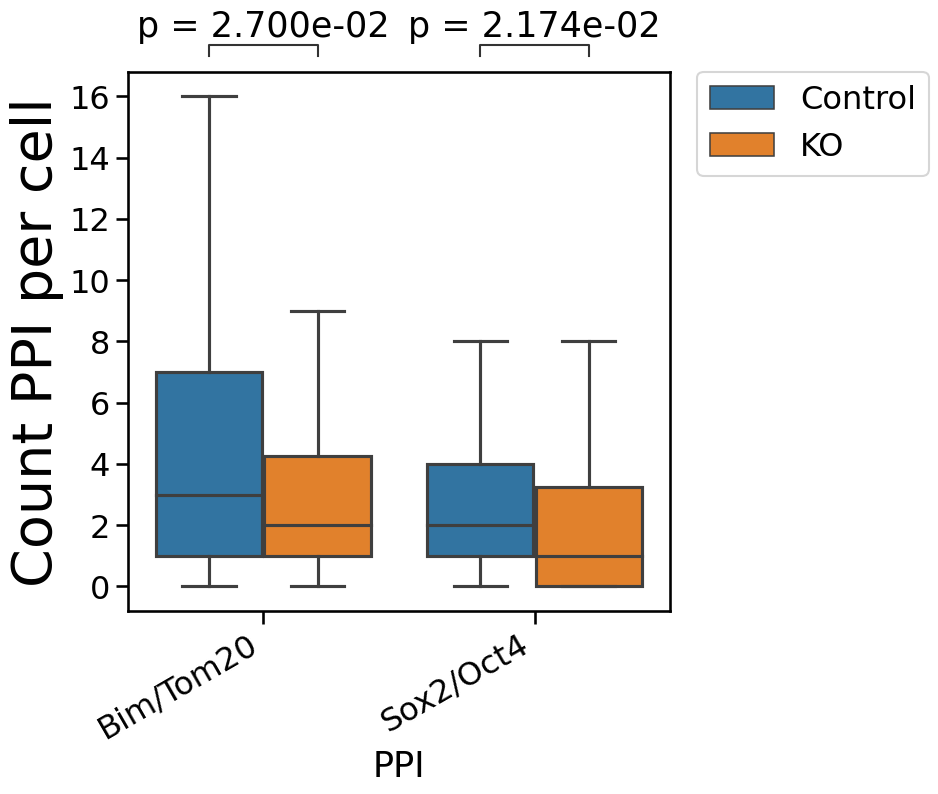

In [13]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

Sox2/Oct4_Control vs. Sox2/Oct4_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:1.015e-01 U_stat=5.506e+03
Bim/Tom20_Control vs. Bim/Tom20_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:5.036e-02 U_stat=5.652e+03


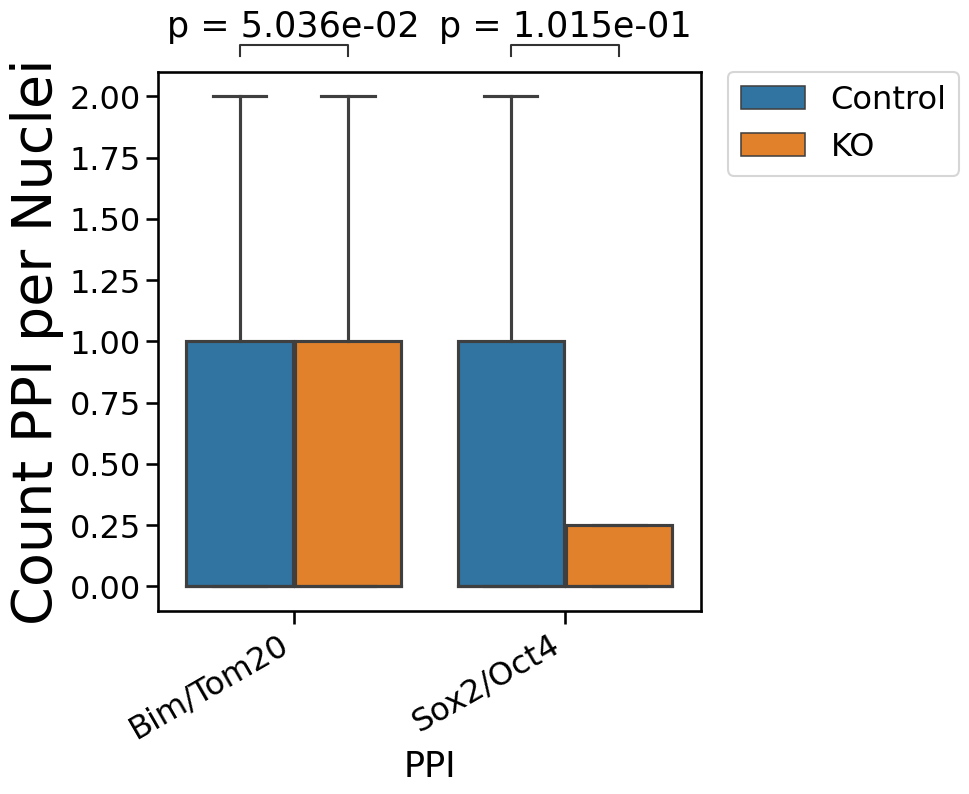

In [14]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting,  y_title='Count PPI per Nuclei')

Sox2/Oct4_Control vs. Sox2/Oct4_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:4.046e-02 U_stat=5.780e+03
Bim/Tom20_Control vs. Bim/Tom20_KO: Mann-Whitney-Wilcoxon test two-sided, P_val:2.982e-02 U_stat=5.834e+03


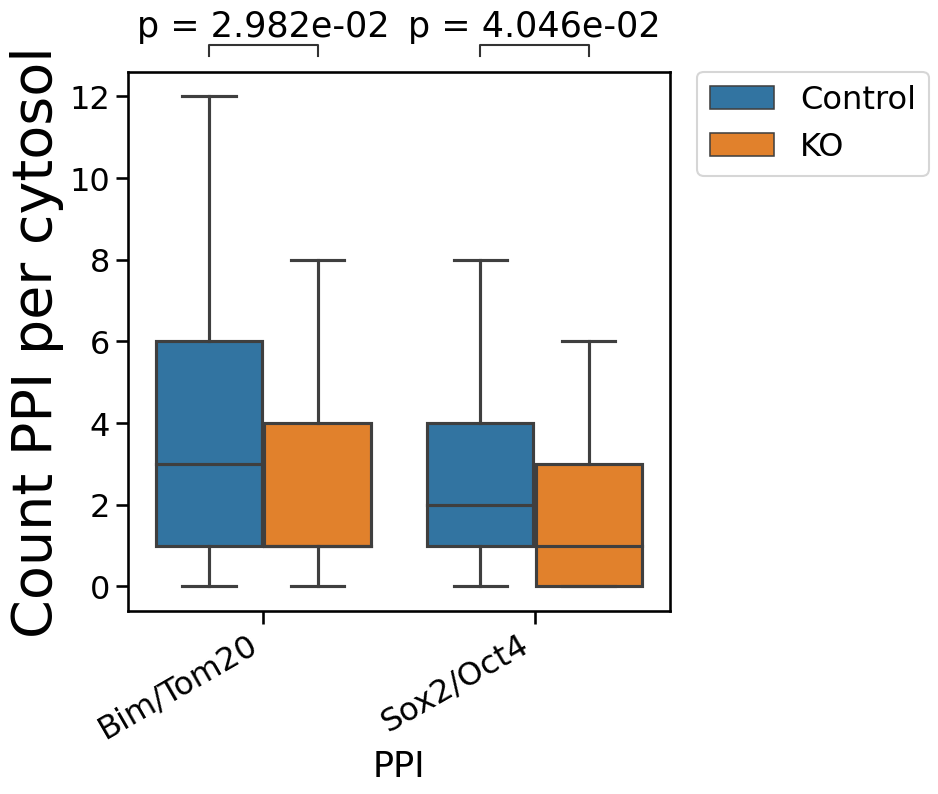

In [15]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting,  y_title='Count PPI per cytosol')

In [16]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cyto'].describe().to_clipboard()